<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

No information on wall, this very nature case which needs the exploration, try to see its relation of generalization to performance 
Pretrain from the full training, but then reduce it to h2h pre

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


## Packages

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

from collections import OrderedDict


import pretrain
from pretrain import *

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

## Model Tranining 
Pretranining is done with fixed size 15,  training is between 10 to 15, test on 19 

Training from zero seems to be better because it will allow the agent to explore from new

In [4]:
2# A complete experiment including pretraining , decoding training, and q learning  
class PretrainTest():
    def __init__(self, weight_write, holes = 0, inputs_type = (1, 0)):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_write
            
    def loadweight(self, weight_load):
#       need to take the state dict as a new dict for updating 
        net_dict = torch.load(weight_load)
        list_modules = [('h2h', net_dict['h2h']), ('a2h', net_dict['a2h']), ('i2h', net_dict['i2h']), ('r2h', net_dict['r2h']), ('bh', net_dict['bh'])]
        select_dict = OrderedDict(list_modules)
        net = self.pregame.net.state_dict()
        net.update(select_dict)
        self.pregame.net.load_state_dict(net)
        torch.save(self.pregame.net.state_dict(), self.weight) 
    
        
    def pretrain(self, trial, weight = None, lr = 1e-5, pretrain = True):  
        # start a pretrained game  
        self.pregame.net.cuda()
        if pretrain == True:
            lr = float(lr)
            if weight != None:
                self.pregame.net.load_state_dict(torch.load(weight))
            self.pregame.fulltrain(lr_rate = lr, trials = int(1e2), batchsize = 4)
        print ('pretrain end', 'module h2h', torch.norm(self.pregame.net.h2h), 'eig real', np.max(self.pregame.net.h2h.eig()[0].cpu().data.numpy()[:,0]),\
                                    'eig img', np.max(self.pregame.net.h2h.eig()[0].cpu().data.numpy()[:,1]))
        if pretrain == True and trial <=10:
            torch.save(self.pregame.net.state_dict(), self.weight[:-1]+'{}'.format(trial))
            
        elif pretrain == True and trial > 10:
            torch.save(self.pregame.net.state_dict(), self.weight[:-2]+'{}'.format(trial))
        elif pretrain == False:
            torch.save(self.pregame.net.state_dict(), self.weight + '{}'.format(trial))
        if pretrain == True and trial <= 10:
            self.weight = self.weight[:-1]+'{}'.format(trial)
        elif pretrain == True and trial > 10:
            self.weight = self.weight[:-2]+'{}'.format(trial)
        elif pretrain == False:
            self.weight = self.weight +'{}'.format(trial)
    
            
    def decode(self, weight = None, size_train = [10], size_test = [10], epsilon = 0, iterations = 160):
        if weight != None:
            self.game.net.load_state_dict(torch.load(weight))
        else:
            self.game.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.experiment(rls_q, rls_sl, iterations = iterations, epsilon = epsilon, train_hidden = False, \
                             train_q = False, size_range = size_train, test = True, decode = True) 
        # tested on size 15
        def precision(size = 15):
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = epsilon)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0, size = size)[0])
#             prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
#             prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1, size = size)[0])
            return prec0
        print ('decode train finish')
        if len(size_test) == 2:
            Prec_s = precision(size = size_test[0])
            Prec_l = precision(size = size_test[1])
            print ('decode end', Prec_s, Prec_l)
            return Prec_s, Prec_l
        elif len(size_test) == 1:
            Prec_s = precision(size = size_test[0])
            print ('decode end', Prec_s)
            return Prec_s
        # q learning session 
    
        
    def qlearn(self, weight_read, weight_write, iterations = 5, save = True,  size_test = [15, 30], train_only = False, test_only = False, noise = 0.3):
        self.pregame.net.load_state_dict(torch.load(weight_read))
        e_rate = [noise for r in range(iterations)] 
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        # q leanring phase
        for n,e in enumerate(e_rate):
            self.game.net.cpu()
            if test_only == False:
                self.game.experiment(rls_q, rls_sl, iterations = 10, epochs= 20, epsilon = e, size_range=(10, 20))    
            if save == True:
                torch.save(self.game.net.state_dict(), weight_write + '_{}'.format(n))
        def testing(game):
            Rewards00 = Test(game, reward_control = 0, size = size_test[0])
            Rewards01 = Test(game, reward_control = 1, size = size_test[0])
            rewards_s = (np.sum(Rewards00) + np.sum(Rewards01))/(2 * self.game.grid_size[0] * self.game.grid_size[1])
            Rewards10 = Test(game, reward_control = 0, size = size_test[1])
            Rewards11 = Test(game, reward_control = 1, size = size_test[1])
            rewards_l = (np.sum(Rewards10) + np.sum(Rewards11))/(2 * self.game.grid_size[0] * self.game.grid_size[1])
            return rewards_s, rewards_l
        # load weight if test only is true 
        if test_only == True:
            self.game.net.load_state_dict(torch.load(weight_write))
        if train_only == False:
            rewards_s, rewards_l = testing(self.game)
        return rewards_s, rewards_l
    
    def TestAllSizes(self, size_range = np.arange(15, 86, 10), limit_set = 8, test_size = None):
        self.game.net.load_state_dict(torch.load(self.weight))
        self.Performance = []
        for size in size_range:
            if test_size == None: 
                test_size = size//25
            else:
                test_size = test_size
            Rewards0 = Test(self.game, reward_control = 0, size = size, test = test_size, limit_set = limit_set)
            Rewards1 = Test(self.game, reward_control = 1, size = size, test = test_size, limit_set = limit_set)
            self.Performance.append((Rewards0 + Rewards1)/2)

## Model Train

**Results can be compared between across different noise level for the initial weights and last 5.  There is a clear trends that training is deproving the generalization performance, but there is actually one exception, the weight 98 is gaining more power to generalize,  the insights is in the next notebook**

it is easy to intepretate this result,  the pretraining is done for the random walk behaviour , not with real action. But decoding is tested as average of 0, 0.5 1  noise level.  So even the pretraining decrease the random walk decoding error along the way, it has no reason to desend the average in a monotonic manner.   The fact that decoding performance under different noise level converges is showing that dynamics goes nearer and nearer to path integrator.  What is hard to intepretate is actually how dynamics are shaped. why integrator is not associate with a infinit timescale  

In [7]:
Precision = []
Pretest =  PretrainTest(weight_write = 'weights{}/rnn_1515tanh512_checkpoint'.format(1), holes = 0)
Pretest.pregame.net.load_state_dict(torch.load('weights1/rnn_1515tanh512_checkpoint15'))
Predicts, targets, hiddens = Pretest.pregame.fulltest(batchsize=1, low = 99, high = 100)

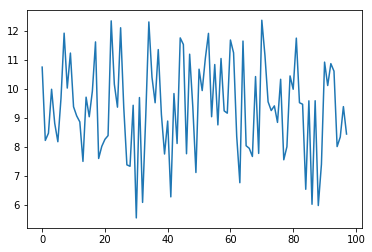

In [8]:
dhs = hiddens[:-1] - hiddens[1:] 
plt.plot([torch.norm(dh).cpu().data.numpy() for dh in dhs])

In [28]:
Predicts[0].size(), targets[0].size()

(torch.Size([1, 5]), torch.Size([1, 5]))

In [29]:
data = [(np.argmax(pre[0].cpu().data.numpy()), np.argmax(target[0].cpu().data.numpy())) for pre, target in zip(Predicts, targets)]

In [10]:
Acc2 = []
for i in np.arange(0, 8, 1):
    accs = []
    for j in range(10):
        Pretest.pregame.net.load_state_dict(torch.load('weights1/rnn_1515tanh512_checkpoint{}'.format(i)))
        Predicts, targets, hiddens = Pretest.pregame.fulltest(batchsize=1, low = 99, high = 100, size_range = [15])
        acc =  [(np.argmax(pre[0].cpu().data.numpy()) == np.argmax(target[0].cpu().data.numpy())) for pre, target in zip(Predicts, targets)]
        accs.extend(acc)
    Acc2.append(np.mean(accs))

In [ ]:
Acc3 = []
Entropy = []
for i in np.arange(0, 49, 1):
    accs = []
    for j in range(10):
        Pretest.pregame.net.load_state_dict(torch.load('weights1/rnn_1515tanh512_checkpoint{}'.format(i)))
        Predicts, targets, hiddens = Pretest.pregame.fulltest(batchsize=1, low = 99, high = 100, size_range = [15])
        acc =  [(np.argmax(pre[0].cpu().data.numpy()) == np.argmax(target[0].cpu().data.numpy())) for pre, target in zip(Predicts, targets)]
        accs.extend(acc)
        def entropy(predict, target):
            return targets * torch.log(F.softmax(predict))
        entropy =  [-entropy(pre, target).cpu().data.numpy() for pre, target in zip(Predicts, targets)]
    Acc3.append(np.mean(accs))
    Entropy.append(np.mean(entropy))

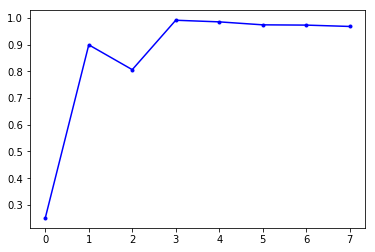

In [20]:
plt.plot(np.arange(0, 8, 1), Acc2, 'b.-')

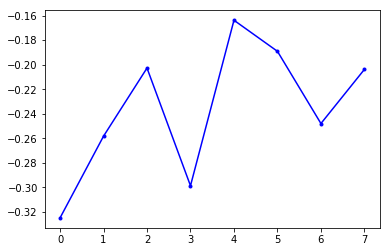

In [23]:
plt.plot(np.arange(0, 8, 1), Entropy, 'b.-')

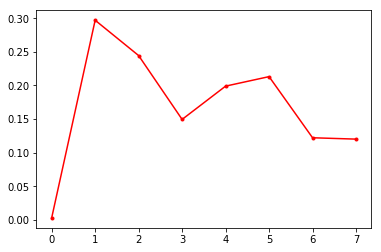

In [15]:
plt.plot(np.arange(0, 8, 1), Acc3, 'r.-')

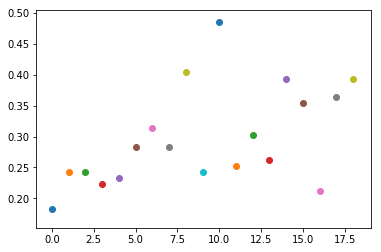

In [52]:
for i in range(19):
    Pretest.pregame.net.load_state_dict(torch.load('weights1/rnn_1515tanh512_checkpoint{}'.format(i)))
    Predicts, targets, hiddens = Pretest.pregame.fulltest(batchsize=1, low = 99, high = 100)
    acc =  [(np.argmax(pre[0].cpu().data.numpy()) == np.argmax(target[0].cpu().data.numpy())) for pre, target in zip(Predicts, targets)]
    plt.scatter(i, np.mean(acc))

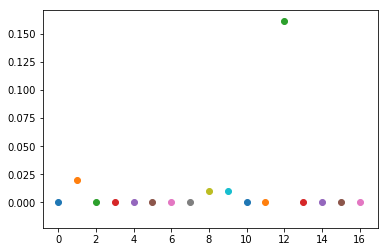

In [49]:
for i in range(17):
    Pretest.pregame.net.load_state_dict(torch.load('weights1/rnn_1515tanh512_checkpoint{}'.format(i)))
    Predicts, targets, hiddens = Pretest.pregame.fulltest(batchsize=1, low = 99, high = 100, size_range = [15])
    acc =  [(np.argmax(pre[0].cpu().data.numpy()) == np.argmax(target[0].cpu().data.numpy())) for pre, target in zip(Predicts, targets)]
    plt.scatter(i, np.mean(acc))

## Decode test 

In [50]:
Pretest =  PretrainTest(weight_write = 'weights{}/rnn_1515tanh512_checkpoint'.format(1), holes = 0)
for i in range(0, 1):
    prec = Pretest.decode(weight = 'weights1/rnn_1515tanh512_checkpoint{}'.format(i), size_train = [15], \
                          size_test= [15], iterations = 20, epsilon = 1)
    print (prec)

clear session data 19 2668802048
decode train finish
decode end 4.11611267994
4.11611267994


In [51]:
Pretest =  PretrainTest(weight_write = 'weights{}/rnn_1515tanh512_checkpoint'.format(16), holes = 0)
for i in range(16, 17):
    prec = Pretest.decode(weight = 'weights1/rnn_1515tanh512_checkpoint{}'.format(i), size_train = [15], \
                          size_test= [15], iterations = 20, epsilon = 1)
    print (prec)

clear session data 19 2668802048
decode train finish
decode end 4.05287866384
4.05287866384


In [53]:
Pretest =  PretrainTest(weight_write = 'weights{}/rnn_1515tanh512_checkpoint'.format(16), holes = 0)
for i in range(99, 100):
    prec = Pretest.decode(weight = 'weights1/rnn_1515tanh512_checkpoint{}'.format(i), size_train = [15], \
                          size_test= [15], iterations = 20, epsilon = 1)
    print (prec)

clear session data 19 2668797952
decode train finish
decode end 4.03703200898
4.03703200898


In [47]:
Pretest =  PretrainTest(weight_write = 'weights{}/rnn_1515tanh512_checkpoint'.format(1), holes = 0)
for i in [0, 10, 15]:
    prec = Pretest.decode(weight = 'weights1/rnn_1515tanh512_checkpoint{}'.format(i), size_train = [5], \
                          size_test= [5], iterations = 20)
    print (prec)

clear session data 19 2668535808
decode train finish
decode end 9.95823032052
9.95823032052
clear session data 19 2668535808
decode train finish
decode end 4.33144121146
4.33144121146
clear session data 19 2668535808
decode train finish
decode end 4.40098934502
4.40098934502


In [28]:
torch.norm(Pretest.pregame.net.h2h)
Weff = Pretest.pregame.net.h2h #+ game.net.h2o.matmul(game.net.a2h)
#     plt.figure()
plt.scatter (Weff.eig()[0][:,0].cpu().data.numpy(), Weff.eig()[0][:,1].cpu().data.numpy(), label = trial)

NameError: name 'trial' is not defined

In [18]:
Pretest.pregame.decoder.I2p

Parameter containing:
tensor([[ 0.2888,  0.5131,  0.5626, -0.0890,  0.4715],
        [-0.2693, -0.3602, -1.1068, -0.4934, -1.0088],
        [ 0.2659,  0.2278,  0.3608,  0.1596, -0.0190],
        ...,
        [-0.2615, -0.0635, -0.1631, -0.2355, -0.0146],
        [-1.3577, -0.3358,  0.3691, -1.4696, -0.0919],
        [-0.1545, -0.1073, -0.9971, -0.6174, -1.0688]], device='cuda:0')

Precision_blank2 = []

for trial in range(30):
    for size in [15, 55, 85]:
        print ('trial', trial)
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(1, 0))
        Prec = Pretest.decode(size_range = [size], size_test = [size])
        Precision_blank2.append(Prec)

    np.save('Precision_blank.npy', Precision_blank2)

Precision_blank_r = []

for trial in range(30): 
    print ('trial', trial)
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(1, 0))
    Prec = Pretest.decode(epsilon = 1)
    Precision_blank_r.append(Prec)

np.save('Precision_blank_random.npy', Precision_blank_r)

In [4]:
Precision_blank_r = []

for trial in range(30, 40): 
    print ('trial', trial)
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial), inputs_type=(1, 0))
    Prec = Pretest.decode(epsilon = 1)
    Precision_blank_r.append(Prec)

np.save('Precision_blank_random_2.npy', Precision_blank_r)

trial 30
clear session data 159 2469203968
decode train finish
decode end 4.452293213645052 6.130852042460522
trial 31
clear session data 159 2434461696
decode train finish
decode end 6.220524009337546 5.703354323962497
trial 32
clear session data 159 2466897920
decode train finish
decode end 4.60266828690292 7.021793003832404
trial 33
clear session data 159 2466897920
decode train finish
decode end 5.404164367808777 5.154143127419681
trial 34
clear session data 159 2467168256
decode train finish
decode end 4.291497006149317 8.02686202937978
trial 35
clear session data 159 2467168256
decode train finish
decode end 4.5859875060979505 6.339443789887617
trial 36
clear session data 159 2467168256
decode train finish
decode end 5.372852841452577 5.318617829068014
trial 37
clear session data 159 2467168256
decode train finish
decode end 5.193085838762101 6.44754837941729
trial 38
clear session data 159 2471460864
decode train finish
decode end 4.950399358757522 6.135692227776004
trial 39
cle

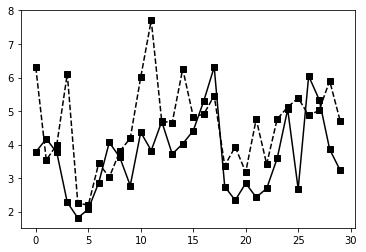

In [11]:
Precision_blank = np.load('Precision_blank.npy')
plt.plot([pre[0] for pre in Precision_blank], 'ks-')
plt.plot([pre[1] for pre in Precision_blank], 'ks--')

(array([ 1, 24]),)

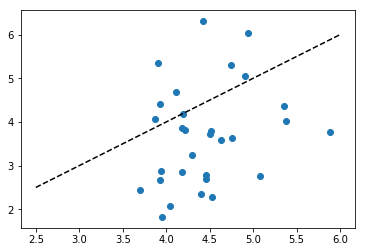

In [10]:
Precision_blank = np.load('Precision_blank.npy')
Precision_blank_random = np.load('Precision_blank_random.npy')
pre0_s = [pre[0] for pre in Precision_blank]
pre0_sr = [pre[0] for pre in Precision_blank_random]
plt.scatter(pre0_sr, pre0_s)
plt.plot(np.linspace(2.5, 6, 100), np.linspace(2.5, 6, 100), 'k--')
np.where(np.abs((np.array(pre0_s) - np.array(pre0_sr)))<0.2)

(array([3]),)

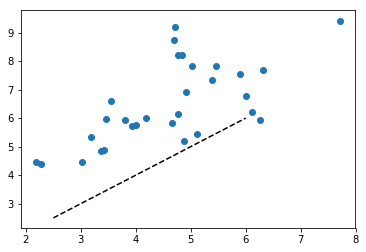

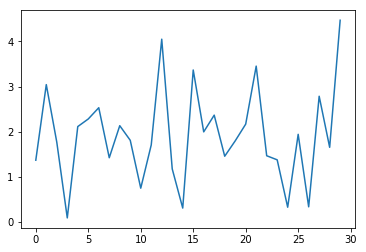

In [11]:
pre0_l = [pre[1] for pre in Precision_blank]
pre0_lr = [pre[1] for pre in Precision_blank_random]
plt.scatter(pre0_l, pre0_lr)
plt.plot(np.linspace(2.5, 6, 100), np.linspace(2.5, 6, 100), 'k--')
plt.figure()
plt.plot(np.abs(np.array(pre0_lr) - np.array(pre0_l)))
np.where(np.abs((np.array(pre0_l) - np.array(pre0_lr)))<0.2)

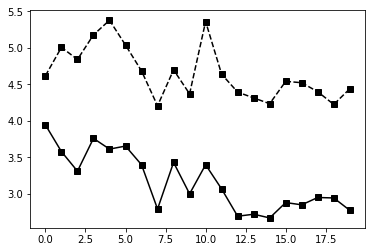

In [5]:
# another results before
Precision_blank = np.load('Precision_blank.npy')
plt.plot([pre[0][0] for pre in Precision_blank], 'ks-')
plt.plot([pre[1][0] for pre in Precision_blank], 'ks--')

### Decoding along Q learning
***Check if behaviour actually also changes prediction, that could explain the powerfulness of action loop on shaping the predictiivity, even though its shows more power in version without action, execept the first iteration, all the others seems to have the trends of increasing decodibility in small size end with q learning, also no matter their intial decoding value , the later stage values are similar**

**The decoding level might be very low associate with the good generalized states, which will show that the good generalized one are without good decoding, in another way, the one with very nice transient and good decoding might not decode well, which will show later**

**The trends of decoding-performance is inverse, the better performance with q leanring,  the worse decoding level.**

In [4]:
Q_learn_decode = []
for iters, trial in enumerate(5 * [38]):
    Precision_qlearn = []
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0))
    for i in range(11): 
        print ('iterations', i)
        if i == 0 : 
            weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)
        else:
            weight = 'weights2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(trial, iters, i-1)
        Prec = Pretest.decode(weight = weight, size_range = [55], size_test = [10])
        Precision_qlearn.append(Prec)
    Q_learn_decode.append(Precision_qlearn)
    np.save('Precision_qlearn.npy', Q_learn_decode)

iterations 0
clear session data 159 2742517760
decode train finish
decode end 26.904373982945536
iterations 1
clear session data 159 2772934656
decode train finish
decode end 43.13429222442041
iterations 2
clear session data 159 2728103936
decode train finish
decode end 37.729624275059216
iterations 3
clear session data 159 2773229568
decode train finish
decode end 27.643294075004057
iterations 4
clear session data 159 2772996096
decode train finish
decode end 38.45896376556499
iterations 5
clear session data 159 2772951040
decode train finish
decode end 37.22295108406419
iterations 6
clear session data 159 2728464384
decode train finish
decode end 37.48871031191211
iterations 7
clear session data 159 2773020672
decode train finish
decode end 38.34380436790539
iterations 8
clear session data 159 2728300544
decode train finish
decode end 43.24357143215411
iterations 9
clear session data 159 2729123840
decode train finish
decode end 39.86033554321658
iterations 10
clear session data 159 

In [28]:
Performance = []
for trial in [0, 7, 9, 13, 15]:
    Precision_qlearn = []
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights1_new/rnn_1515tanh512_checkpoint0', inputs_type=(1, 0))
    performance = []
    for i in range(10):
        Pretest0 = PretrainTest(holes = 0, weight_write = 'weights2/rnn_1515tanh512_checkpoint0_{}_{}'.format(trial, i), inputs_type=(1, 0))
        Pretest0.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0)
        print (Pretest0.Performance)
        performance.append(Pretest0.Performance)
    Performance.append(performance)
    np.save('Performance_qlearn.npy', Performance)

FileNotFoundError: [Errno 2] No such file or directory: 'weights2/rnn_1515tanh512_checkpoint0_0_0'

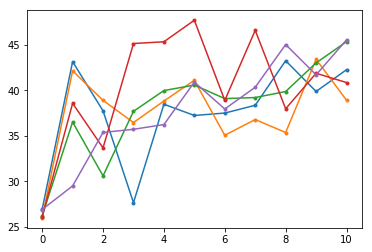

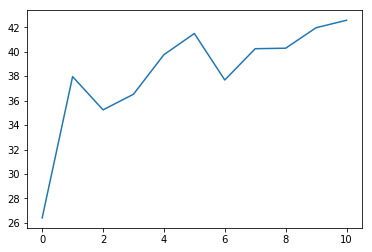

In [5]:
for qlearn in Q_learn_decode:
    plt.plot(qlearn, '.-')
plt.figure()
plt.plot(np.mean(np.array(Q_learn_decode), axis = 0))

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **